In [203]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import keras
from keras.layers import Dense
from keras.models import Sequential

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

In [204]:
# getting data
corpus_df, val_corpus_df, emotion_df, val_emotion_df, valence_df, val_valence_df = get_labeled_dfs()


In [205]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [206]:
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,two hussein ally hang iraqi official say
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


# Exploratory Data Analysis

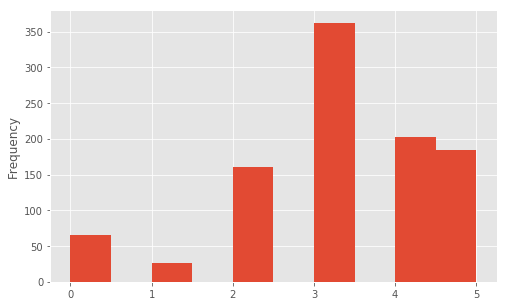

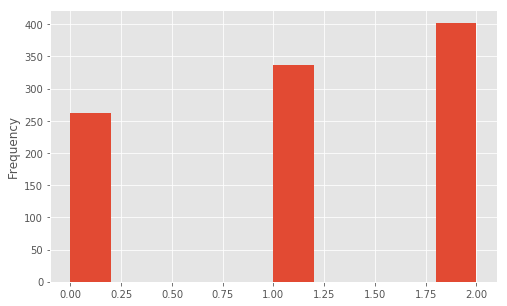

In [160]:
# distribution of classes
plt.figure(figsize=(8,5))
emotion_df['label'].plot(kind='hist')
plt.figure(figsize=(8,5))
valence_df['label'].plot(kind='hist')
plt.show()

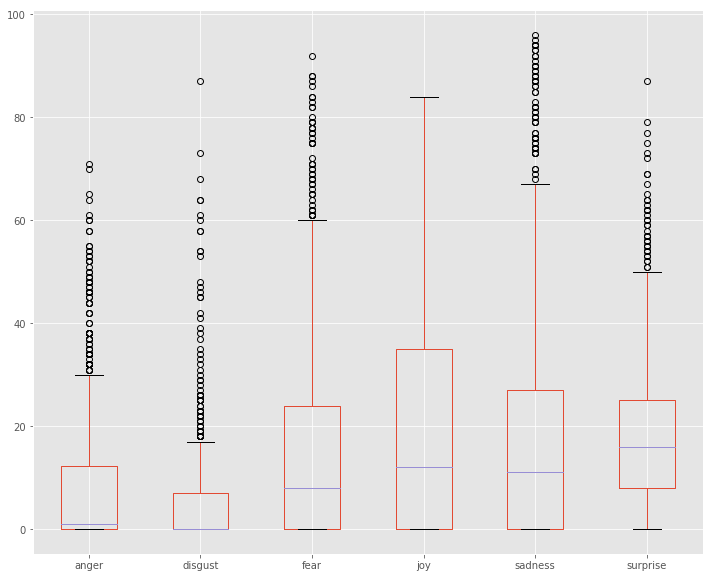

In [161]:
# boxplot showing the disribution of scores for each emotion category
plt.figure(figsize=(12,10))
emotion_df.iloc[:,:-1].boxplot()

In [162]:
# there are no entries with rating 0. for all emotion categories, but there are entries with very small values across the board
emotion_df.loc[(emotion_df.anger==0)&(emotion_df.disgust==0)&(emotion_df.fear==0)&(emotion_df.joy==0)&(emotion_df.sadness==0)& (emotion_df.surprise==0)]
emotion_df.loc[(emotion_df.anger + emotion_df.disgust + emotion_df.fear + emotion_df.joy + emotion_df.sadness + emotion_df.surprise)<15]


,anger,disgust,fear,joy,sadness,surprise,max,label
20,2,2,0,0,0,10,surprise,5
73,0,0,0,0,0,14,surprise,5
98,0,0,9,0,3,2,fear,2
200,0,0,5,1,1,6,surprise,5
217,4,0,4,0,3,0,anger,0
231,0,0,0,2,0,0,joy,3
375,0,0,0,9,0,2,joy,3
480,0,0,0,3,0,11,surprise,5
536,0,0,0,5,0,2,joy,3
640,0,0,0,2,0,1,joy,3


In [163]:
# creating another neutral/low_emotion category to separate especially low values
# total = (emotion_df.anger + emotion_df.disgust + emotion_df.fear + emotion_df.joy + emotion_df.sadness + emotion_df.surprise)

# old_labels = [i for i in emotion_df.label]
# new_label_list = []

# for i,v in enumerate(total):
#     if total[i] <= 15:
#         new_label_list.append(7)
#     else:
#         new_label_list.append(old_labels[i])

# emotion_df['new_label'] = new_label_list

In [164]:
# emotion_df.new_label.value_counts()

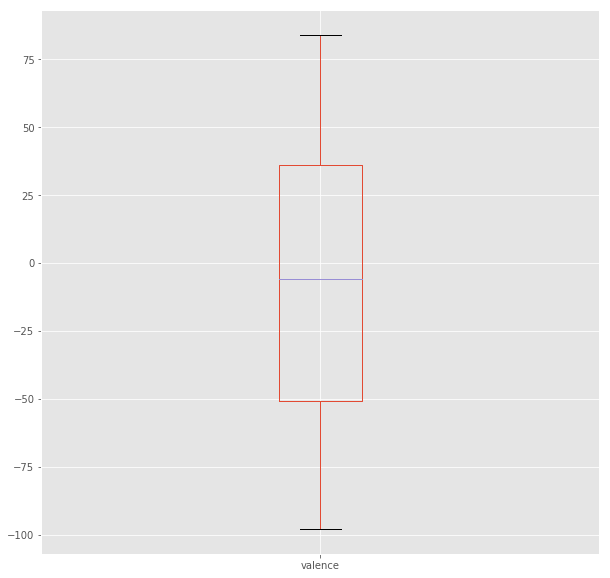

In [165]:
# boxplot showing the disribution of valencescores 
plt.figure(figsize=(10,10))
valence_df['valence'].plot(kind='box')

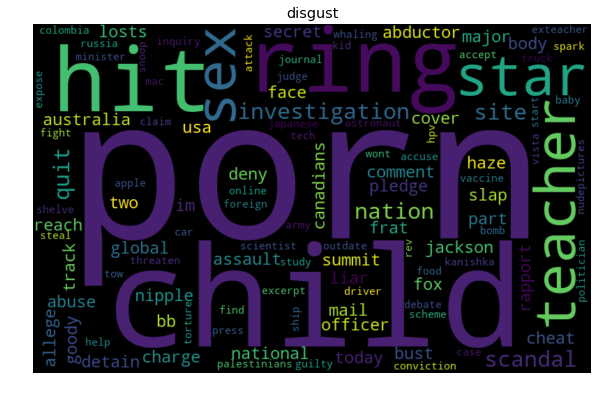

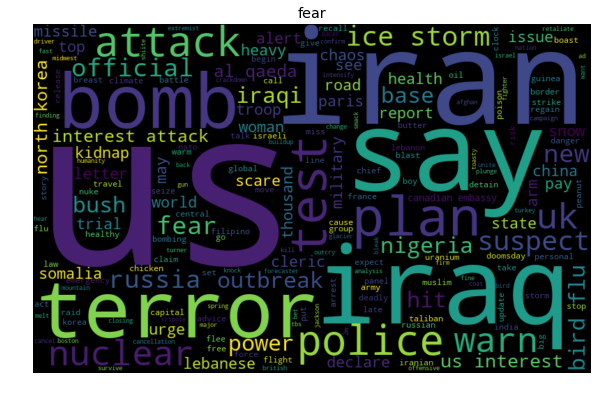

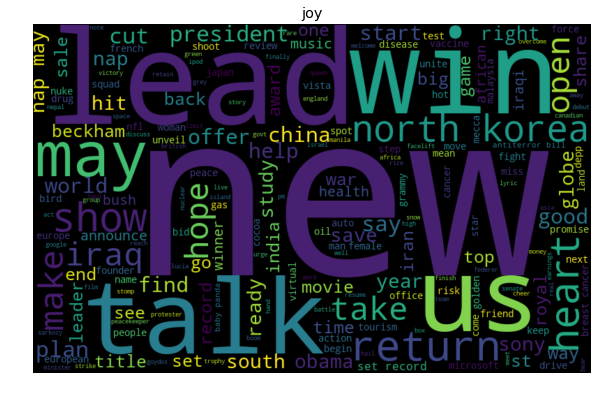

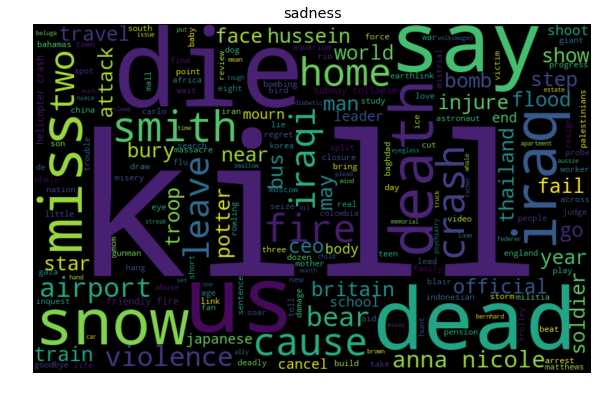

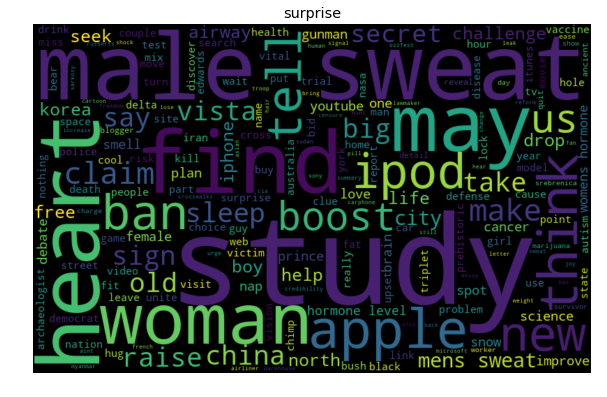

In [166]:
for i in list(emotion_df.columns[1:-2]):
    
    indexes = []
    for index, val in enumerate(emotion_df['max']):
        if val==i:
            indexes.append(index)
    
    single_emotion = corpus_df['text'][indexes] 
    word_string =' '.join([i for i in single_emotion])

    wordcloud = WordCloud(width=800, height=500, random_state=42).generate(word_string)
    plt.figure(figsize=(10, 7))
    plt.title(i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    

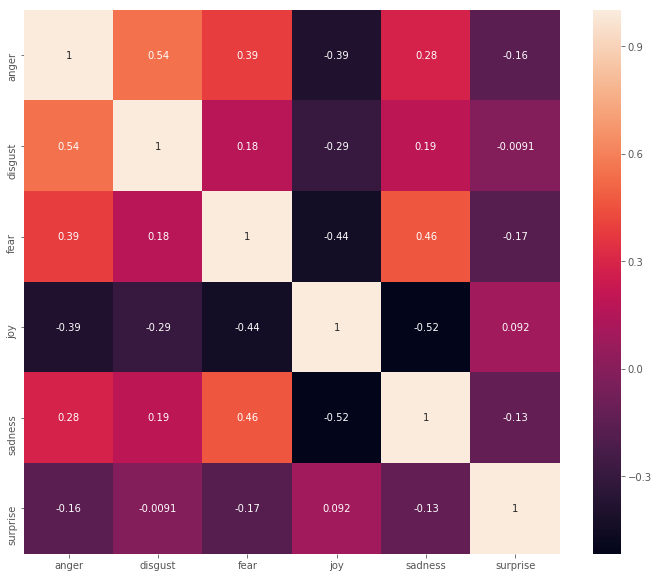

In [167]:
# correlations among emotion categories
plt.figure(figsize=(12,10))
corr = emotion_df.iloc[:,:-1].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

# Models

## Strong Pos/Neg Valence only

In [174]:
X = corpus_df['text'].iloc[y.index]
y = valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==2)]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [175]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape

(553, 1573)

In [176]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape


(602, 1573)

In [177]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(max_depth=25)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
lr_classifier = LogisticRegression(C=1e10)

nb_classifier.fit(X_res, y_res)
nb_train_preds = nb_classifier.predict(X_res)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

rf_classifier.fit(X_res, y_res)
rf_train_preds = rf_classifier.predict(X_res)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

knn_classifier.fit(X_res, y_res)
knn_train_preds = knn_classifier.predict(X_res)
knn_test_preds = knn_classifier.predict(tf_idf_X_test)

lr_classifier.fit(X_res, y_res)
lr_train_preds = lr_classifier.predict(X_res)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Multinomial Naive Bayes
Training Accuracy: 0.9900332225913622
Training F1: 0.9900331125827814
Testing Accuracy: 0.7675675675675676
Testing F1: 0.767920880628063


Random Forest
Training Accuracy: 0.8504983388704319
Training F1: 0.9900331125827814
Testing Accuracy: 0.6810810810810811
Testing F1: 0.6626669307548722


K Nearest Neighbors
Training Accuracy: 0.6129568106312292
Training F1: 0.5461278851163107
Testing Accuracy: 0.6108108108108108
Testing F1: 0.5712608536137949


Logistic Regression
Training Accuracy: 1.0
Training F1: 1.0
Testing Accuracy: 0.7675675675675676
Testing F1: 0.7668098079407762


Text(373.36363636363626, 0.5, 'Predicted')

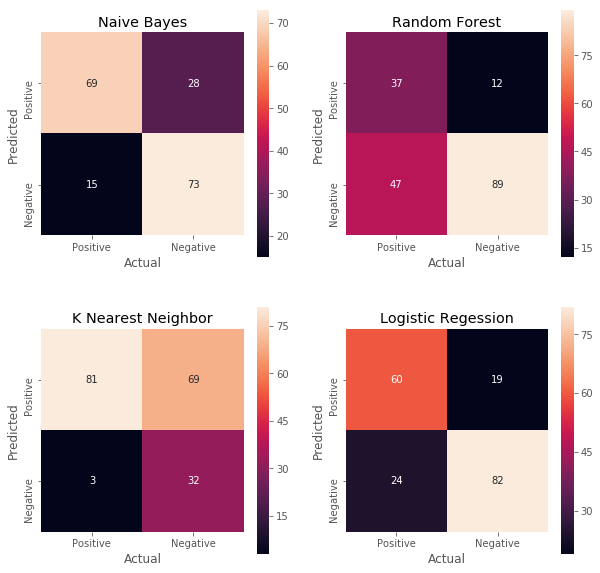

In [179]:
nb_train_acc = accuracy_score(y_res, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_res, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average='weighted')
rf_train_acc = accuracy_score(y_res, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_res, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average='weighted')
knn_train_acc = accuracy_score(y_res, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_res, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average='weighted')
lr_train_acc = accuracy_score(y_res, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_res, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average='weighted')

# note that the the high negative class is being treated as the target 

print("Multinomial Naive Bayes")
print("Training Accuracy:", nb_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", nb_test_acc)
print("Testing F1:", nb_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Positive', 'Negative'], xticklabels=['Positive', 'Negative'])
plt.title('Naive Bayes')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Random Forest')
print("Training Accuracy:", rf_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", rf_test_acc)
print("Testing F1:", rf_test_f1)
print("\n")
plt.subplot(2,2,2)
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Positive', 'Negative'], xticklabels=['Positive', 'Negative'])
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('K Nearest Neighbors')
print("Training Accuracy:", knn_train_acc)
print("Training F1:", knn_train_f1)
print("Testing Accuracy:", knn_test_acc)
print("Testing F1:", knn_test_f1)
print("\n")
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, knn_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Positive', 'Negative'], xticklabels=['Positive', 'Negative'])
plt.title('K Nearest Neighbor')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Logistic Regression')
print("Training Accuracy:", lr_train_acc)
print("Training F1:", lr_train_f1)
print("Testing Accuracy:", lr_test_acc)
print("Testing F1:", lr_test_f1)
plt.subplot(2,2,4)
cm = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Positive', 'Negative'], xticklabels=['Positive', 'Negative'])
plt.title('Logistic Regession')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [ ]:
df = pd.DataFrame({"true": y_test, "predicted":knn_test_preds})
len(df.loc[(df.true==1) & (df.predicted==2)])

## All valence categories

In [180]:
X = corpus_df['text']
y = valence_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)


In [181]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape


(750, 1987)

In [182]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape


(903, 1987)

In [183]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(max_depth=25)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
lr_classifier = LogisticRegression(C=1e10)

nb_classifier.fit(X_res, y_res)
nb_train_preds = nb_classifier.predict(X_res)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

rf_classifier.fit(X_res, y_res)
rf_train_preds = rf_classifier.predict(X_res)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

knn_classifier.fit(X_res, y_res)
knn_train_preds = knn_classifier.predict(X_res)
knn_test_preds = knn_classifier.predict(tf_idf_X_test)

lr_classifier.fit(X_res, y_res)
lr_train_preds = lr_classifier.predict(X_res)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Multinomial Naive Bayes
Training Accuracy: 0.9712070874861573
Training F1: 0.9712317404961653
Testing Accuracy: 0.488
Testing F1: 0.49115946799400556


Random Forest
Training Accuracy: 0.7541528239202658
Training F1: 0.9712317404961653
Testing Accuracy: 0.432
Testing F1: 0.39096080722251725


K Nearest Neighbors
Training Accuracy: 0.6522702104097453
Training F1: 0.6005687532223641
Testing Accuracy: 0.352
Testing F1: 0.3351773010925506


Logistic Regression
Training Accuracy: 0.9988925802879292
Training F1: 0.9988925772321605
Testing Accuracy: 0.5
Testing F1: 0.491255159214651


Text(373.36363636363626, 0.5, 'Predicted')

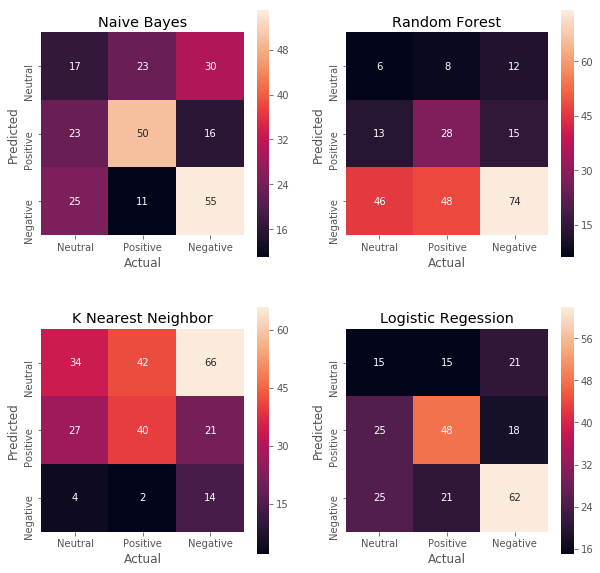

In [184]:
nb_train_acc = accuracy_score(y_res, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_res, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average='weighted')
rf_train_acc = accuracy_score(y_res, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_res, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average='weighted')
knn_train_acc = accuracy_score(y_res, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_res, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average='weighted')
lr_train_acc = accuracy_score(y_res, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_res, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average='weighted')

# note that the the high negative class is being treated as the target 

print("Multinomial Naive Bayes")
print("Training Accuracy:", nb_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", nb_test_acc)
print("Testing F1:", nb_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Neutral', 'Positive', 'Negative'], xticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Naive Bayes')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Random Forest')
print("Training Accuracy:", rf_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", rf_test_acc)
print("Testing F1:", rf_test_f1)
print("\n")
plt.subplot(2,2,2)
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Neutral', 'Positive', 'Negative'], xticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('K Nearest Neighbors')
print("Training Accuracy:", knn_train_acc)
print("Training F1:", knn_train_f1)
print("Testing Accuracy:", knn_test_acc)
print("Testing F1:", knn_test_f1)
print("\n")
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, knn_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Neutral', 'Positive', 'Negative'], xticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('K Nearest Neighbor')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Logistic Regression')
print("Training Accuracy:", lr_train_acc)
print("Training F1:", lr_train_f1)
print("Testing Accuracy:", lr_test_acc)
print("Testing F1:", lr_test_f1)
plt.subplot(2,2,4)
cm = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Neutral', 'Positive', 'Negative'], xticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Logistic Regession')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [185]:
df = pd.DataFrame({"true": y_test, "predicted":lr_test_preds})
len(df.loc[(df.true==2) & (df.predicted==1)])

18

## Emotion categories

In [186]:
X = corpus_df['text']
y = emotion_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)


In [187]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape


(750, 2005)

In [188]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape


(1632, 2005)

In [189]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(max_depth=25)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
lr_classifier = LogisticRegression(C=1e10)

nb_classifier.fit(X_res, y_res)
nb_train_preds = nb_classifier.predict(X_res)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

rf_classifier.fit(X_res, y_res)
rf_train_preds = rf_classifier.predict(X_res)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

knn_classifier.fit(X_res, y_res)
knn_train_preds = knn_classifier.predict(X_res)
knn_test_preds = knn_classifier.predict(tf_idf_X_test)

lr_classifier.fit(X_res, y_res)
lr_train_preds = lr_classifier.predict(X_res)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Multinomial Naive Bayes
Training Accuracy: 0.960171568627451
Training F1: 0.9599046857314203
Testing Accuracy: 0.46
Testing F1: 0.4669701411469934


Random Forest
Training Accuracy: 0.7696078431372549
Training F1: 0.9599046857314203
Testing Accuracy: 0.492
Testing F1: 0.4503149256877443


K Nearest Neighbors
Training Accuracy: 0.7824754901960784
Training F1: 0.7478936929113738
Testing Accuracy: 0.368
Testing F1: 0.3640737523217929


Logistic Regression
Training Accuracy: 0.9993872549019608
Training F1: 0.9993872528314213
Testing Accuracy: 0.52
Testing F1: 0.5192602564102564


Text(373.36363636363626, 0.5, 'Predicted')

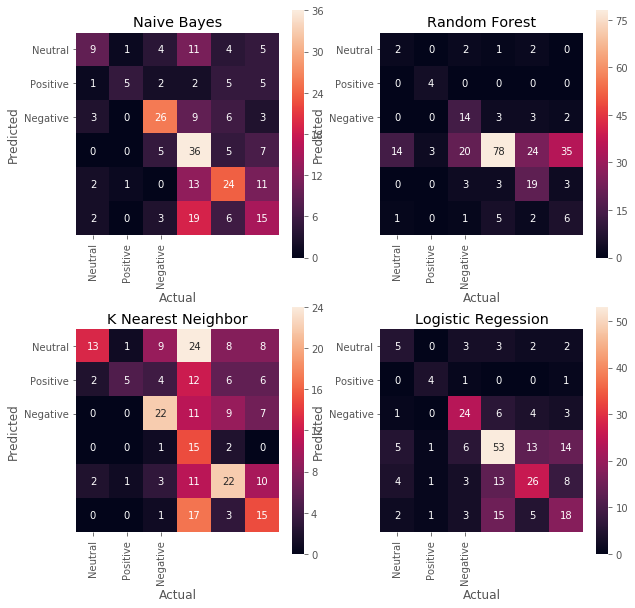

In [190]:
nb_train_acc = accuracy_score(y_res, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_res, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average='weighted')
rf_train_acc = accuracy_score(y_res, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_res, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average='weighted')
knn_train_acc = accuracy_score(y_res, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_res, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average='weighted')
lr_train_acc = accuracy_score(y_res, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_res, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average='weighted')

# note that the the high negative class is being treated as the target 

print("Multinomial Naive Bayes")
print("Training Accuracy:", nb_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", nb_test_acc)
print("Testing F1:", nb_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Neutral', 'Positive', 'Negative'], xticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Naive Bayes')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Random Forest')
print("Training Accuracy:", rf_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", rf_test_acc)
print("Testing F1:", rf_test_f1)
print("\n")
plt.subplot(2,2,2)
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Neutral', 'Positive', 'Negative'], xticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('K Nearest Neighbors')
print("Training Accuracy:", knn_train_acc)
print("Training F1:", knn_train_f1)
print("Testing Accuracy:", knn_test_acc)
print("Testing F1:", knn_test_f1)
print("\n")
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, knn_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Neutral', 'Positive', 'Negative'], xticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('K Nearest Neighbor')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Logistic Regression')
print("Training Accuracy:", lr_train_acc)
print("Training F1:", lr_train_f1)
print("Testing Accuracy:", lr_test_acc)
print("Testing F1:", lr_test_f1)
plt.subplot(2,2,4)
cm = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Neutral', 'Positive', 'Negative'], xticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Logistic Regession')
plt.xlabel('Actual')
plt.ylabel('Predicted')

## Neural Network: Strong Pos/Neg Valence 

In [281]:
ind = valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==2)].index
y = valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==2)]
X = corpus_df['text'].iloc[ind]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
y_res = pd.get_dummies(y_res).values
X_res.shape

num_features = 1573
num_classes = 2

model = Sequential()
# first layer, includes input shape
model.add(Dense(300, activation='relu', input_shape=(num_features, )))
# second layer
model.add(Dense(150, activation='relu'))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=100,
                    batch_size=250,
                    validation_data=(tf_idf_X_test, y_test))

ValueError: Error when checking target: expected dense_136 to have shape (2,) but got array with shape (1,)

In [282]:
y_res

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

## Neural Network: All Valence Labels

In [235]:
X = corpus_df['text']
y = valence_df['label']

from keras.utils import to_categorical
y_binary = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y, random_state=42)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape

num_features = 2017
num_classes = 3

model = Sequential()
# first layer, includes input shape
model.add(Dense(300, activation='relu', input_shape=(num_features, )))
# second layer
model.add(Dense(150, activation='relu'))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=100,
                    batch_size=250,
                    validation_data=(tf_idf_X_test, y_test))

Train on 906 samples, validate on 250 samples
Epoch 1/100
906/906 [==============================] - 1s 1ms/step - loss: 1.0958 - acc: 0.3631 - val_loss: 1.0922 - val_acc: 0.4600
Epoch 2/100
906/906 [==============================] - 0s 144us/step - loss: 1.0642 - acc: 0.8168 - val_loss: 1.0813 - val_acc: 0.5440
Epoch 3/100
906/906 [==============================] - 0s 104us/step - loss: 1.0217 - acc: 0.9338 - val_loss: 1.0659 - val_acc: 0.5640
Epoch 4/100
906/906 [==============================] - 0s 127us/step - loss: 0.9558 - acc: 0.9746 - val_loss: 1.0428 - val_acc: 0.5640
Epoch 5/100
906/906 [==============================] - 0s 141us/step - loss: 0.8546 - acc: 0.9812 - val_loss: 1.0061 - val_acc: 0.5920
Epoch 6/100
906/906 [==============================] - 0s 126us/step - loss: 0.7140 - acc: 0.9879 - val_loss: 0.9641 - val_acc: 0.5880
Epoch 7/100
906/906 [==============================] - 0s 100us/step - loss: 0.5442 - acc: 0.9890 - val_loss: 0.9308 - val_acc: 0.5880
Epoch 8/100

906/906 [==============================] - 0s 145us/step - loss: 0.0040 - acc: 0.9978 - val_loss: 1.7905 - val_acc: 0.5680
Epoch 62/100
906/906 [==============================] - 0s 141us/step - loss: 0.0040 - acc: 0.9967 - val_loss: 1.7965 - val_acc: 0.5600
Epoch 63/100
906/906 [==============================] - 0s 101us/step - loss: 0.0039 - acc: 0.9978 - val_loss: 1.8023 - val_acc: 0.5600
Epoch 64/100
906/906 [==============================] - 0s 92us/step - loss: 0.0039 - acc: 0.9978 - val_loss: 1.8068 - val_acc: 0.5640
Epoch 65/100
906/906 [==============================] - 0s 157us/step - loss: 0.0038 - acc: 0.9978 - val_loss: 1.8127 - val_acc: 0.5640
Epoch 66/100
906/906 [==============================] - 0s 144us/step - loss: 0.0040 - acc: 0.9978 - val_loss: 1.8186 - val_acc: 0.5600
Epoch 67/100
906/906 [==============================] - 0s 144us/step - loss: 0.0039 - acc: 0.9978 - val_loss: 1.8219 - val_acc: 0.5640
Epoch 68/100
906/906 [==============================] - 0s 148

250/250 [==============================] - 0s 139us/step
[2.204259609222412, 0.496]


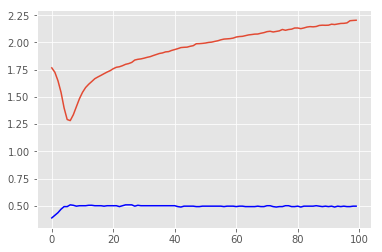

In [226]:
print(model.evaluate(tf_idf_X_test, y_test))

plt.plot(history.history['val_acc'], color='blue')
plt.plot(history.history['val_loss'])

## Neural Network: Emotion Labels

In [224]:
X = corpus_df['text']
y = emotion_df['label']

from keras.utils import to_categorical
y_binary = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y, random_state=42)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape

num_features = 2050
num_classes = 6

model = Sequential()
# first layer, includes input shape
model.add(Dense(300, activation='relu', input_shape=(num_features, )))
# second layer
model.add(Dense(150, activation='relu'))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=100,
                    batch_size=250,
                    validation_data=(tf_idf_X_test, y_test))

Train on 1626 samples, validate on 250 samples
Epoch 1/100
1626/1626 [==============================] - 1s 447us/step - loss: 1.7771 - acc: 0.3542 - val_loss: 1.7667 - val_acc: 0.3880
Epoch 2/100
1626/1626 [==============================] - 0s 139us/step - loss: 1.6933 - acc: 0.8075 - val_loss: 1.7263 - val_acc: 0.4120
Epoch 3/100
1626/1626 [==============================] - 0s 112us/step - loss: 1.5265 - acc: 0.9071 - val_loss: 1.6489 - val_acc: 0.4360
Epoch 4/100
1626/1626 [==============================] - 0s 119us/step - loss: 1.2290 - acc: 0.9600 - val_loss: 1.5427 - val_acc: 0.4680
Epoch 5/100
1626/1626 [==============================] - 0s 145us/step - loss: 0.8280 - acc: 0.9785 - val_loss: 1.3988 - val_acc: 0.4920
Epoch 6/100
1626/1626 [==============================] - 0s 137us/step - loss: 0.4488 - acc: 0.9865 - val_loss: 1.2922 - val_acc: 0.4920
Epoch 7/100
1626/1626 [==============================] - 0s 169us/step - loss: 0.2052 - acc: 0.9902 - val_loss: 1.2820 - val_acc: 0

1626/1626 [==============================] - 0s 91us/step - loss: 0.0022 - acc: 0.9988 - val_loss: 2.0403 - val_acc: 0.4960
Epoch 61/100
1626/1626 [==============================] - 0s 85us/step - loss: 0.0024 - acc: 0.9982 - val_loss: 2.0501 - val_acc: 0.4920
Epoch 62/100
1626/1626 [==============================] - 0s 87us/step - loss: 0.0024 - acc: 0.9982 - val_loss: 2.0544 - val_acc: 0.4960
Epoch 63/100
1626/1626 [==============================] - 0s 100us/step - loss: 0.0025 - acc: 0.9988 - val_loss: 2.0563 - val_acc: 0.4960
Epoch 64/100
1626/1626 [==============================] - 0s 84us/step - loss: 0.0023 - acc: 0.9988 - val_loss: 2.0628 - val_acc: 0.4920
Epoch 65/100
1626/1626 [==============================] - 0s 86us/step - loss: 0.0021 - acc: 0.9988 - val_loss: 2.0694 - val_acc: 0.4920
Epoch 66/100
1626/1626 [==============================] - 0s 113us/step - loss: 0.0025 - acc: 0.9982 - val_loss: 2.0728 - val_acc: 0.4920
Epoch 67/100
1626/1626 [============================

250/250 [==============================] - 0s 116us/step
[1.9364340343475341, 0.5520000009536743]


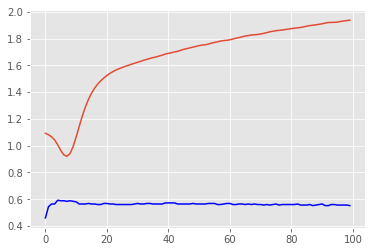

In [236]:
print(model.evaluate(tf_idf_X_test, y_test))

plt.plot(history.history['val_acc'], color='blue')
plt.plot(history.history['val_loss'])

## RNN

Train on 664 samples, validate on 74 samples
Epoch 1/15
664/664 [==============================] - 5s 7ms/step - loss: 0.6940 - acc: 0.5075 - val_loss: 0.6945 - val_acc: 0.4865
Epoch 2/15
664/664 [==============================] - 2s 3ms/step - loss: 0.6865 - acc: 0.5557 - val_loss: 0.6950 - val_acc: 0.4865
Epoch 3/15
664/664 [==============================] - 2s 3ms/step - loss: 0.6734 - acc: 0.5527 - val_loss: 0.6924 - val_acc: 0.4865
Epoch 4/15
664/664 [==============================] - 2s 3ms/step - loss: 0.6509 - acc: 0.5919 - val_loss: 0.6807 - val_acc: 0.4865
Epoch 5/15
664/664 [==============================] - 2s 3ms/step - loss: 0.6012 - acc: 0.7078 - val_loss: 0.6509 - val_acc: 0.6351
Epoch 6/15
664/664 [==============================] - 2s 3ms/step - loss: 0.4973 - acc: 0.8690 - val_loss: 0.5920 - val_acc: 0.6892
Epoch 7/15
664/664 [==============================] - 2s 3ms/step - loss: 0.3357 - acc: 0.9608 - val_loss: 0.5091 - val_acc: 0.8243
Epoch 8/15
664/664 [===========

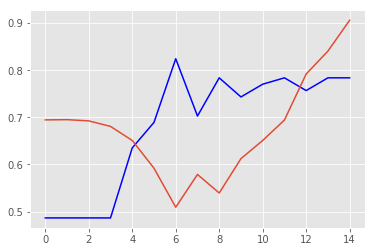

In [257]:
# Trying Word Embeddings

## straight from Learn.co

data = corpus_df['text'].apply(lambda x: x.split())
total_vocabulary = set(word for headline in data for word in headline)

import numpy as np
glove = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note from Mike: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # It can't be used in a sklearn Pipeline. 
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

ind = valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==2)].index
X = corpus_df['text'].iloc[ind]
y = pd.get_dummies(valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==2)]).values

# X = corpus_df['text']
# y = pd.get_dummies(valence_df['label']).values

tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))
list_tokenized_headlines = tokenizer.texts_to_sequences(X)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

embedding_size = 128
input_ = Input(shape=(100,))
x = Embedding(20000, embedding_size)(input_)
x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
# There are 2 different possible classes, so we use 41 neurons in our output layer
x = Dense(2, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_t, y, epochs=15, batch_size=50, validation_split=0.1)

plt.plot(model.history.history['val_acc'], color='blue')
plt.plot(model.history.history['val_loss'])

